In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import random
import gymnasium as gym
from gymnasium import Env, spaces
from scipy.special import comb
from collections import defaultdict, deque

In [3]:
with open('pickles/anonbank_lognorm_params.pkl', 'rb') as f:
    lognorm_params_df = pickle.load(f)
    
lognorm_params_dict = lognorm_params_df.set_index('param_name').T.to_dict()

lognorm_params_dict

{('1', 'REGULAR'): {'mu': 4.832017135463374,
  'sigma': 0.006958469079704907,
  'loc': -18.81216413263904},
 ('1', 'SPECIFIC'): {'mu': 4.6755415208149325,
  'sigma': 0.011323646523065594,
  'loc': -6.43006717763892},
 ('2', 'REGULAR'): {'mu': 5.0125526231624855,
  'sigma': 0.005548307071802354,
  'loc': -8.97654648869145},
 ('2', 'SPECIFIC'): {'mu': 4.617186601308905,
  'sigma': 0.010134016947128502,
  'loc': -4.806412598886724},
 'REGULAR': {'mu': 3.7589339214345716,
  'sigma': 0.024480564633599006,
  'loc': -2.846758403840244},
 'SPECIFIC': {'mu': 4.650110366782741,
  'sigma': 0.01083819523964822,
  'loc': -5.260938954957395},
 'REGULAR_x4': {'mu': 5.145228282554465,
  'sigma': 0.006121000886257698,
  'loc': -11.387033615361277},
 'SPECIFIC_x4': {'mu': 6.036404727902634,
  'sigma': 0.002709623408600959,
  'loc': -21.043755819830228}}

In [4]:
with open('pickles/anonbank_service_rate.pkl', 'rb') as f:
    service_rate = pickle.load(f)

# Convert service_rate to a dictionary for easier access
ser_rate_dict = service_rate.set_index(['group', 'type_group'])[['mean_service_time', 'std']].to_dict('index')

ser_rate_dict

{('1', 'REGULAR'): {'mean_service_time': 12.641068214208262,
  'std': 274.09685054233046},
 ('1', 'SPECIFIC'): {'mean_service_time': 14.229164478664519,
  'std': 447.916748807343},
 ('2', 'REGULAR'): {'mean_service_time': 19.02417781821472,
  'std': 344.9407640049321},
 ('2', 'SPECIFIC'): {'mean_service_time': 15.020757462895316,
  'std': 257.32365209990894}}

In [5]:

# Global variables

# Queue size
MAX_QUEUE_SIZE = 20

# Discount factor for future rewards
DISCOUNT = 0.95

# Penalty for dropping calls (when queue is full)
DROP_PENALTY = 3600.0 # 1 hour in seconds

# State space: (queue 1 size, queue 2 size, call type)
STATE_SPACE = (MAX_QUEUE_SIZE + 1, MAX_QUEUE_SIZE + 1, 2)

# Call type: 0 = regular, 1 = specific
CALL_TYPE = [0, 1]

# Actions: 0 = route to queue 1, 1 = route to queue 2
ACTIONS = [1, 2]

# Arrival parameters for regular and specific calls
ARRIVAL_REGULAR_MU = lognorm_params_dict['REGULAR']['mu']
ARRIVAL_REGULAR_SIGMA = lognorm_params_dict['REGULAR']['sigma']
ARRIVAL_REGULAR_LOC = lognorm_params_dict['REGULAR']['loc']
ARRIVAL_SPECIFIC_MU = lognorm_params_dict['SPECIFIC']['mu']
ARRIVAL_SPECIFIC_SIGMA = lognorm_params_dict['SPECIFIC']['sigma']
ARRIVAL_SPECIFIC_LOC = lognorm_params_dict['SPECIFIC']['loc']

SERVICE_REGULAR_1_MU = lognorm_params_dict[('1', 'REGULAR')]['mu']
SERVICE_REGULAR_1_SIGMA = lognorm_params_dict[('1', 'REGULAR')]['sigma']
SERVICE_REGULAR_1_LOC = lognorm_params_dict[('1', 'REGULAR')]['loc']
SERVICE_SPECIFIC_1_MU = lognorm_params_dict[('1', 'SPECIFIC')]['mu']
SERVICE_SPECIFIC_1_SIGMA = lognorm_params_dict[('1', 'SPECIFIC')]['sigma']
SERVICE_SPECIFIC_1_LOC = lognorm_params_dict[('1', 'SPECIFIC')]['loc']

SERVICE_REGULAR_2_MU = lognorm_params_dict[('2', 'REGULAR')]['mu']
SERVICE_REGULAR_2_SIGMA = lognorm_params_dict[('2', 'REGULAR')]['sigma']
SERVICE_REGULAR_2_LOC = lognorm_params_dict[('2', 'REGULAR')]['loc']
SERVICE_SPECIFIC_2_MU = lognorm_params_dict[('2', 'SPECIFIC')]['mu']
SERVICE_SPECIFIC_2_SIGMA = lognorm_params_dict[('2', 'SPECIFIC')]['sigma']
SERVICE_SPECIFIC_2_LOC = lognorm_params_dict[('2', 'SPECIFIC')]['loc']

def mean_shifted_lognormal(mu, sigma, loc):
    """
    Calculate mean of shifted lognormal distribution:
    E[X] = exp(mu + sigma^2 / 2) + loc
    """
    return np.exp(mu + (sigma**2) / 2) + loc

def std_shifted_lognormal(mu, sigma, loc):
    """
    Calculate standard deviation of shifted lognormal distribution:
    The location (loc) shifts the mean but does not affect the std.
    """
    return np.sqrt((np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2))

# Arrival rates

ARRIVAL_REGULAR = mean_shifted_lognormal(
    ARRIVAL_REGULAR_MU,
    ARRIVAL_REGULAR_SIGMA,
    ARRIVAL_REGULAR_LOC
)

ARRIVAL_SPECIFIC = mean_shifted_lognormal(
    ARRIVAL_SPECIFIC_MU,
    ARRIVAL_SPECIFIC_SIGMA,
    ARRIVAL_SPECIFIC_LOC
)

ARRIVAL_REGULAR_STD = std_shifted_lognormal(
    ARRIVAL_REGULAR_MU,
    ARRIVAL_REGULAR_SIGMA,
    ARRIVAL_REGULAR_LOC   
)

ARRIVAL_SPECIFIC_STD = std_shifted_lognormal(
    ARRIVAL_SPECIFIC_MU,
    ARRIVAL_SPECIFIC_SIGMA,
    ARRIVAL_SPECIFIC_LOC
)

# Service means and std

SERVICE_REGULAR_1 = ser_rate_dict[('1', 'REGULAR')]['mean_service_time']
SERVICE_SPECIFIC_1 = ser_rate_dict[('1', 'SPECIFIC')]['mean_service_time']
SERVICE_REGULAR_2 = ser_rate_dict[('2', 'REGULAR')]['mean_service_time']
SERVICE_SPECIFIC_2 = ser_rate_dict[('2', 'SPECIFIC')]['mean_service_time']

SERVICE_REGULAR_1_STD = ser_rate_dict[('1', 'REGULAR')]['std']
SERVICE_SPECIFIC_1_STD = ser_rate_dict[('1', 'SPECIFIC')]['std']
SERVICE_REGULAR_2_STD = ser_rate_dict[('2', 'REGULAR')]['std']
SERVICE_SPECIFIC_2_STD = ser_rate_dict[('2', 'SPECIFIC')]['std']

# SERVICE_REGULAR_1 = mean_shifted_lognormal(
#     SERVICE_REGULAR_1_MU,
#     SERVICE_REGULAR_1_SIGMA,
#     SERVICE_REGULAR_1_LOC
# )

# SERVICE_REGULAR_2 = mean_shifted_lognormal(
#     SERVICE_REGULAR_2_MU,
#     SERVICE_REGULAR_2_SIGMA,
#     SERVICE_REGULAR_2_LOC
# )

# SERVICE_SPECIFIC_1 = mean_shifted_lognormal(
#     SERVICE_SPECIFIC_1_MU,
#     SERVICE_SPECIFIC_1_SIGMA,
#     SERVICE_SPECIFIC_1_LOC
# )

# SERVICE_SPECIFIC_2 = mean_shifted_lognormal(
#     SERVICE_SPECIFIC_2_MU,
#     SERVICE_SPECIFIC_2_SIGMA,
#     SERVICE_SPECIFIC_2_LOC
# )

In [6]:
print("MEANS:")

print(f"ARRIVAL_REGULAR: {ARRIVAL_REGULAR}, ARRIVAL_SPECIFIC: {ARRIVAL_SPECIFIC}")
print(f"SERVICE_REGULAR_1: {SERVICE_REGULAR_1}, SERVICE_SPECIFIC_1: {SERVICE_SPECIFIC_1}")
print(f"SERVICE_REGULAR_2: {SERVICE_REGULAR_2}, SERVICE_SPECIFIC_2: {SERVICE_SPECIFIC_2}") 

print("STD:")

print(f"ARRIVAL_REGULAR: {ARRIVAL_REGULAR_STD}, ARRIVAL_SPECIFIC: {ARRIVAL_SPECIFIC_STD}")
print(f"SERVICE_REGULAR_1: {SERVICE_REGULAR_1_STD}, SERVICE_SPECIFIC_1: {SERVICE_SPECIFIC_1_STD}")
print(f"SERVICE_REGULAR_2: {SERVICE_REGULAR_2_STD}, SERVICE_SPECIFIC_2: {SERVICE_SPECIFIC_2_STD}")

MEANS:
ARRIVAL_REGULAR: 40.068763243462236, ARRIVAL_SPECIFIC: 99.34173344076834
SERVICE_REGULAR_1: 12.641068214208262, SERVICE_SPECIFIC_1: 14.229164478664519
SERVICE_REGULAR_2: 19.02417781821472, SERVICE_SPECIFIC_2: 15.020757462895316
STD:
ARRIVAL_REGULAR: 1.050753626188135, ARRIVAL_SPECIFIC: 1.1337374798875093
SERVICE_REGULAR_1: 274.09685054233046, SERVICE_SPECIFIC_1: 447.916748807343
SERVICE_REGULAR_2: 344.9407640049321, SERVICE_SPECIFIC_2: 257.32365209990894


In [7]:
# Lognormal expected value calculation

def expected_waiting_time_binom_kingman(q_size, p_regular, mean_r, mean_s, rho, ca, cs):
    """
    Calculate expected waiting time for a queue with q_size calls,
    each call being regular with probability p_regular,
    using direct mean service times for regular and specific calls.
    """
    # Expected waiting time
    EWq = 0.0
    for k in range(q_size + 1):
        # Binomial probability of k regular calls in the queue
        prob = comb(q_size, k) * (p_regular ** k) * ((1 - p_regular) ** (q_size - k))
        # Waiting time if k regular and (q_size - k) specific ahead
        wait_k = k * mean_r + (q_size - k) * mean_s
        EWq += prob * wait_k
        
    # Kingman scaling
    Km = rho / (1 - rho) * (ca ** 2 + cs ** 2) / 2

    return EWq * Km

def expected_waiting_time_binom(q_size, p_regular, mean_r, mean_s):
    """
    Calculate expected waiting time for a queue with q_size calls,
    each call being regular with probability p_regular,
    using direct mean service times for regular and specific calls.
    """
    # Expected waiting time
    wait = 0.0
    for k in range(q_size + 1):
        # Binomial probability of k regular calls in the queue
        prob = comb(q_size, k) * (p_regular ** k) * ((1 - p_regular) ** (q_size - k))
        # Waiting time if k regular and (q_size - k) specific ahead
        wait_k = k * mean_r + (q_size - k) * mean_s
        wait += prob * wait_k

    return wait

def rho(rate_regular, rate_specific, mean_r, mean_s):
    """
    Calculate the traffic intensity (rho) for the queue.
    """
    rate_total = rate_regular + rate_specific
    mean_comb = (rate_regular / rate_total * mean_r) + (rate_specific / rate_total * mean_s)
    
    rhoo = rate_total * mean_comb
    if rhoo >= 1:
        return float('inf')  # Avoid division by zero or negative values
    return rhoo

def cv2(var, mean):
    return var / (mean ** 2)

def combined_ca2(rate_regular, rate_specific, ca_regular, ca_specific):
    """
    Calculate the combined coefficient of variation squared for the arrival process.
    """
    rate_total = rate_regular + rate_specific
    
    return (rate_regular / rate_total) * ca_regular + (rate_specific / rate_total) * ca_specific

def combined_cs2(mean_regular, mean_specific, cs_regular, cs_specific):
    """
    Calculate the combined coefficient of variation squared for the service process.
    """
    rate_regular = 1 / mean_regular
    rate_specific = 1 / mean_specific
    rate_total = rate_regular + rate_specific
    mean_comb = (rate_regular / rate_total * mean_regular) + (rate_specific / rate_total * mean_specific)
    
    term1 = (rate_regular / rate_total) * cs_regular
    term2 = (rate_specific / rate_total) * cs_specific
    term3 = rate_regular / rate_total * ((mean_regular - mean_comb) / mean_comb) ** 2
    term4 = rate_specific / rate_total * ((mean_specific - mean_comb) / mean_comb) ** 2
    
    return term1 + term2 + term3 + term4

In [8]:
# Example usage to calculate expected waiting time for queue 1:

rate_regular = 1 / ARRIVAL_REGULAR
rate_specific = 1 / ARRIVAL_SPECIFIC
rate_total = rate_regular + rate_specific

p_regular = rate_regular / rate_total

mean_r1 = SERVICE_REGULAR_1
mean_s1 = SERVICE_SPECIFIC_1

rho1 = rho(rate_regular, rate_specific, mean_r1, mean_s1)

meana_r = ARRIVAL_REGULAR
meana_s = ARRIVAL_SPECIFIC
vara_r = ARRIVAL_REGULAR_STD ** 2
vara_s = ARRIVAL_SPECIFIC_STD ** 2

ca_r = cv2(vara_r, meana_r)
ca_s = cv2(vara_s, meana_s)

vars_r1 = SERVICE_REGULAR_1_STD ** 2
vars_s1 = SERVICE_SPECIFIC_1_STD ** 2

cs_r1 = cv2(vars_r1, mean_r1)
cs_s1 = cv2(vars_s1, mean_s1)

ca = combined_ca2(rate_regular, rate_specific, ca_r, ca_s)
cs_1 = combined_cs2(mean_r1, mean_s1, cs_r1, cs_s1)

q_size = 10 # Example queue size

expected_wait = expected_waiting_time_binom_kingman(q_size, p_regular, mean_r1, mean_s1, rho1, ca, cs_1)
print(f"Expected waiting time at queue 1 (Kingman): {expected_wait:.4f}")

# Compare with queue 2

mean_r2 = SERVICE_REGULAR_2
mean_s2 = SERVICE_SPECIFIC_2

rho2 = rho(rate_regular, rate_specific, mean_r2, mean_s2)

vars_r2 = SERVICE_REGULAR_2_STD ** 2
vars_s2 = SERVICE_SPECIFIC_2_STD ** 2

cs_r2 = cv2(vars_r2, mean_r2)
cs_s2 = cv2(vars_s2, mean_s2)

cs_2 = combined_cs2(mean_r2, mean_s2, cs_r2, cs_s2)

expected_wait2 = expected_waiting_time_binom_kingman(q_size, p_regular, mean_r2, mean_s2, rho2, ca, cs_2)
print(f"Expected waiting time at queue 2 (Kingman): {expected_wait2:.4f}")

Expected waiting time at queue 1 (Kingman): 28384089.2543
Expected waiting time at queue 2 (Kingman): 14287191.6796


In [9]:
expected_wait = expected_waiting_time_binom(q_size, p_regular, mean_r1, mean_s1)
print(f"Expected waiting time at queue 1 (Binom): {expected_wait:.4f}")
expected_wait2 = expected_waiting_time_binom(q_size, p_regular, mean_r2, mean_s2)
print(f"Expected waiting time at queue 2 (Binom): {expected_wait2:.4f}")

Expected waiting time at queue 1 (Binom): 130.9751
Expected waiting time at queue 2 (Binom): 178.7353


In [10]:
# Calculate departure probability
r1_rate = 1 / mean_r1
r2_rate = 1 / mean_r2
s1_rate = 1 / mean_s1
s2_rate = 1 / mean_s2

total_rate = rate_regular + rate_specific + r1_rate + r2_rate + s1_rate + s2_rate

print(f"Departure probability for REGULAR, Queue 1: {r1_rate / total_rate:.4f}")
print(f"Departure probability for REGULAR, Queue 2: {r2_rate / total_rate:.4f}")
print(f"Departure probability for SPECIFIC, Queue 1: {s1_rate / total_rate:.4f}")
print(f"Departure probability for SPECIFIC, Queue 2: {s2_rate / total_rate:.4f}")

Departure probability for REGULAR, Queue 1: 0.2606
Departure probability for REGULAR, Queue 2: 0.1732
Departure probability for SPECIFIC, Queue 1: 0.2315
Departure probability for SPECIFIC, Queue 2: 0.2193


### Use binomial expected waiting time

In [11]:
def plot_results(costs, Q_table, max_queue_size):
    """Plot learning curve and learned policies."""
    
    # Plot learning curve
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(costs, alpha=0.3, label="Episode Cost")
    window = 100
    if len(costs) > window:
        smoothed = pd.Series(costs).rolling(window).mean()
        plt.plot(smoothed, color='red', linewidth=2, label=f"Smoothed (window={window})")
    plt.title("Q-Learning: Cost vs Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Cost")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot learned policies
    policy_regular = np.zeros((max_queue_size + 1, max_queue_size + 1), dtype=int)
    policy_specific = np.zeros((max_queue_size + 1, max_queue_size + 1), dtype=int)

    for q1 in range(max_queue_size + 1):
        for q2 in range(max_queue_size + 1):
            # Regular call policy
            s_regular = (q1, q2, 0)
            if s_regular in Q_table:
                policy_regular[q1, q2] = np.argmax(Q_table[s_regular])
            
            # Specific call policy
            s_specific = (q1, q2, 1)
            if s_specific in Q_table:
                policy_specific[q1, q2] = np.argmax(Q_table[s_specific])

    # Plot policies
    plt.subplot(1, 3, 2)
    ax = sns.heatmap(np.flipud(policy_regular), cmap="RdYlBu", annot=True, 
                     cbar_kws={'label': '0=Queue1, 1=Queue2'})
    plt.title('Learned Policy: Regular Calls')
    plt.ylabel('Queue 1 Length')
    plt.xlabel('Queue 2 Length')
    ax.invert_yaxis()
    
    plt.subplot(1, 3, 3)
    ax = sns.heatmap(np.flipud(policy_specific), cmap="RdYlBu", annot=True,
                cbar_kws={'label': '0=Queue1, 1=Queue2'})
    plt.title('Learned Policy: Specific Calls')
    plt.ylabel('Queue 1 Length') 
    plt.xlabel('Queue 2 Length')
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

In [12]:
class EventBasedCallCentreEnv(gym.Env):
    """
    Event-based RL environment for a two-queue call centre.
    Each step represents a call arrival requiring a routing decision.
    State: (queue1_length, queue2_length, call_type)
    Action: 0 = route to queue 1, 1 = route to queue 2
    Reward: Negative expected waiting time (cost to minimize)
    """
    
    def __init__(self, 
                 max_queue_size=10,
                 drop_penalty=1000.0,
                 arr_scaler = 1.0,
                 arrival_regular_mean=None,
                 arrival_specific_mean=None,
                 service_regular_1=None,
                 service_specific_1=None,
                 service_regular_2=None,
                 service_specific_2=None,
                 seed=None):
        """
        Initialize the event-based call centre environment.
        """
        super().__init__()
        
        self.max_queue_size = max_queue_size
        self.drop_penalty = drop_penalty
        self.arr_scaler = arr_scaler
        
        # Use provided parameters or defaults from your original code
        self.arrival_params = {
            'regular': {
                'mean': arrival_regular_mean / self.arr_scaler,  # Default values
                'mu': ARRIVAL_REGULAR_MU,      # These would come from your lognorm_params
                'sigma': ARRIVAL_REGULAR_SIGMA,
                'loc': ARRIVAL_REGULAR_LOC
            },
            'specific': {
                'mean': arrival_specific_mean / self.arr_scaler,
                'mu': ARRIVAL_SPECIFIC_MU,
                'sigma': ARRIVAL_SPECIFIC_SIGMA,
                'loc': ARRIVAL_SPECIFIC_LOC
            }
        }
        
        # Service parameters
        self.service_times = {
            (1, 'regular'): service_regular_1,
            (1, 'specific'): service_specific_1,
            (2, 'regular'): service_regular_2,
            (2, 'specific'): service_specific_2,
        }
        
        # Calculate arrival rates and probabilities
        arrival_regular_rate = 1.0 / self.arrival_params['regular']['mean']
        arrival_specific_rate = 1.0 / self.arrival_params['specific']['mean']
        self.total_arrival_rate = arrival_regular_rate + arrival_specific_rate
        self.p_regular = arrival_regular_rate / self.total_arrival_rate
        
        # Define observation and action spaces
        self.observation_space = spaces.Box(
            low=np.array([0, 0, 0]), 
            high=np.array([max_queue_size, max_queue_size, 1]), 
            dtype=np.int32
        )
        self.action_space = spaces.Discrete(2)
        
        # Initialize state
        self.queue_lengths = [0, 0]
        self.current_time = 0.0
        self.episode_step = 0
        
        self.queue_contents = [[], []]  # Contents of each queue (list of tuples: (call_type, arrival_time))
        
        if seed is not None:
            self.seed(seed)
            
        # Initialize next arrival times for each call type
        self.next_regular_arrival = 0.0
        self.next_specific_arrival = 0.0
        
        self.current_call_type, _ = self._get_next_call_info()
        
        # Generate initial arrival times
        self._generate_next_arrivals()
        
    def seed(self, seed=None):
        """Set random seed for reproducibility."""
        if seed is not None:
            np.random.seed(seed)
            random.seed(seed)
            self.np_random = np.random.RandomState(seed)
    
    def _generate_lognormal_interarrival(self, call_type):
        """Generate next inter-arrival time using lognormal distribution."""
        params = self.arrival_params[call_type]
        
        # Generate from lognormal distribution
        sample = np.random.lognormal(params['mu'], params['sigma'])
        # Add location parameter (shift)
        interarrival_time = sample + params['loc']
        # Scale the interarrival
        interarrival_time /= self.arr_scaler
        
        return max(interarrival_time, 0.1)
    
    def _generate_next_arrivals(self):
        """Generate next arrival times for both call types."""
        # Always generate next regular arrival if current one is used/passed
        if self.next_regular_arrival <= self.current_time or self.next_regular_arrival == float('inf'):
            regular_interarrival = self._generate_lognormal_interarrival('regular')
            self.next_regular_arrival = self.current_time + regular_interarrival
        
        # Always generate next specific arrival if current one is used/passed  
        if self.next_specific_arrival <= self.current_time or self.next_specific_arrival == float('inf'):
            specific_interarrival = self._generate_lognormal_interarrival('specific')
            self.next_specific_arrival = self.current_time + specific_interarrival

    def _get_next_call_info(self):
        """Determine which call arrives next and when."""
        # Ensure we have valid next arrival times
        self._generate_next_arrivals()
        
        if self.next_regular_arrival <= self.next_specific_arrival:
            # Regular call arrives next
            elapsed_time = self.next_regular_arrival - self.current_time
            call_type = 0  # regular
            # Mark this arrival as used
            self.next_regular_arrival = float('inf')
        else:
            # Specific call arrives next
            elapsed_time = self.next_specific_arrival - self.current_time
            call_type = 1  # specific
            # Mark this arrival as used
            self.next_specific_arrival = float('inf')
        
        return call_type, elapsed_time

    
    def _process_service_completions(self, elapsed_time):
        """
        Process service completions for two independent servers.
        Each queue has its own server with different service times.
        """
        for queue_idx in range(2):  # Two independent servers
            if len(self.queue_contents[queue_idx]) == 0:
                continue
                
            # Process the first call in each queue (FIFO within each server)
            call_type, arrival_time = self.queue_contents[queue_idx][0]
            call_type_str = 'regular' if call_type == 0 else 'specific'
            
            # Time this call has been in the system
            time_in_system = self.current_time - arrival_time + elapsed_time
            
            # Get service time for THIS specific server
            mean_service_time = self.service_times[(queue_idx + 1, call_type_str)]
            
            # Exponential service completion check
            service_rate = 1.0 / mean_service_time
            completion_prob = 1.0 - np.exp(-service_rate * elapsed_time)  # Use elapsed_time, not cumulative
            
            if np.random.random() < completion_prob:
                # Call completed at this server
                self.queue_contents[queue_idx].pop(0)
                self.queue_lengths[queue_idx] = len(self.queue_contents[queue_idx])
    
    def expected_waiting_time_binomial(self, queue_idx, call_type):
        """
        Calculate expected waiting time using binomial mixture of call types.
        This is the same calculation as in your original code.
        """
        queue_size = self.queue_lengths[queue_idx]
        
        if queue_size == 0:
            return 0.0
        
        # Service times for this queue
        mean_regular = self.service_times[(queue_idx + 1, 'regular')]
        mean_specific = self.service_times[(queue_idx + 1, 'specific')]
        
        # Calculate expected waiting time using binomial mixture
        expected_wait = 0.0
        for k in range(queue_size + 1):
            prob = comb(queue_size, k) * (self.p_regular ** k) * ((1 - self.p_regular) ** (queue_size - k))
            wait_time = k * mean_regular + (queue_size - k) * mean_specific
            expected_wait += prob * wait_time
        
        return expected_wait
    
    def reset(self, seed=None, options=None):
        """Reset environment to initial state."""
        if seed is not None:
            self.seed(seed)
        
        self.queue_lengths = [0, 0]
        self.queue_contents = [[], []]
        self.current_time = 0.0
        self.episode_step = 0
        
        # Reset arrival times
        self.next_regular_arrival = 0.0
        self.next_specific_arrival = 0.0
        self._generate_next_arrivals()
        
        self.current_call_type, _ = self._get_next_call_info()
        
        return self._get_state(self.current_call_type), {}
    
    def _get_state(self, call_type):
        """Get current state as numpy array."""
        return np.array([
            self.queue_lengths[0], 
            self.queue_lengths[1], 
            call_type
        ], dtype=np.int32)
    
    def step(self, action):
        """Execute action and return next state, reward, done, info."""
        # Use the current call that was determined in reset() or previous step
        call_type = self.current_call_type
        call_type_str = 'regular' if call_type == 0 else 'specific'
        
        # Get the elapsed time for this call
        _, elapsed_time = self._get_current_call_timing()
        
        # Update current time
        self.current_time += elapsed_time
        
        # Process service completions during this inter-arrival time
        self._process_service_completions(elapsed_time)
        
        reward = 0.0
        dropped = False
        expected_wait = 0.0
        
        # Check if queue is full
        if self.queue_lengths[action] >= self.max_queue_size:
            reward = -self.drop_penalty
            dropped = True
            expected_wait = None
        else:
            # Calculate expected waiting time for this call
            expected_wait = self.expected_waiting_time_binomial(action, call_type)
            reward = -expected_wait
            # Add call to chosen queue
            self.queue_contents[action].append((call_type, self.current_time))
            self.queue_lengths[action] += 1
        
        # Update step counter
        self.episode_step += 1
        
        # NOW generate the NEXT call for the next step
        self.current_call_type, _ = self._get_next_call_info()
        
        # Determine if episode should continue
        terminated = False
        truncated = self.episode_step >= 1000  # Max episode length
        
        info = {
            'queue_1_length': self.queue_lengths[0],
            'queue_2_length': self.queue_lengths[1],
            'call_type': call_type_str,
            'chosen_queue': action + 1 if not dropped else None,
            'expected_wait': expected_wait,
            'dropped': dropped,
            'reward': reward,
            'current_time': self.current_time,
            'episode_step': self.episode_step,
            'elapsed_time': elapsed_time,
            'next_call_type': 'regular' if self.current_call_type == 0 else 'specific',
            'queue_1_contents': len(self.queue_contents[0]),
            'queue_2_contents': len(self.queue_contents[1]),
            'next_regular_arrival': self.next_regular_arrival,
            'next_specific_arrival': self.next_specific_arrival
        }
        
        return self._get_state(self.current_call_type), reward, terminated, truncated, info
    
    def _get_current_call_timing(self):
        """Get timing for the current call without consuming arrival streams."""
        self._generate_next_arrivals()
        
        if self.current_call_type == 0:  # regular
            elapsed_time = self.next_regular_arrival - self.current_time
            # Mark this arrival as used
            self.next_regular_arrival = float('inf')
        else:  # specific
            elapsed_time = self.next_specific_arrival - self.current_time
            # Mark this arrival as used
            self.next_specific_arrival = float('inf')
        
        return self.current_call_type, max(elapsed_time, 0.01)
    
    def render(self, mode='human'):
        """Render current state."""
        if hasattr(self, '_current_call_type'):
            call_type_str = 'Regular' if self._current_call_type == 0 else 'Specific'
        else:
            call_type_str = 'Unknown'
        
        print(f"Step {self.episode_step} | Time: {self.current_time:.1f}s | Queue 1: {self.queue_lengths[0]:2d} | Queue 2: {self.queue_lengths[1]:2d} | Current Call: {call_type_str}")
    
    def get_state_info(self):
        """Get detailed state information for analysis."""
        call_type = self.current_call_type
        call_type_str = 'Regular' if call_type == 0 else 'Specific'
        
        wait_q1 = self.expected_waiting_time_binomial(0, call_type)
        wait_q2 = self.expected_waiting_time_binomial(1, call_type)
        
        return {
            'queue_1_length': self.queue_lengths[0],
            'queue_2_length': self.queue_lengths[1],
            'call_type': call_type_str,
            'p_regular': self.p_regular,
            'expected_wait_q1': wait_q1,
            'expected_wait_q2': wait_q2,
            'optimal_choice': 1 if wait_q1 <= wait_q2 else 2,
            'current_time': self.current_time,
            'episode_step': self.episode_step
        }


In [13]:
def q_learning_with_debugging(
    env,
    num_episodes=10000,
    max_steps_per_episode=200,
    alpha=0.2,
    gamma=0.9,
    epsilon_start=0.9,
    epsilon_min=0.05,
    epsilon_decay=0.9995
):
    """
    Q-learning with debugging information and proper gym environment handling.
    """
    Q = defaultdict(lambda: np.zeros(2))  # Two actions: queue 1 or 2
    episode_costs = []
    epsilon = epsilon_start
    
    for episode in range(num_episodes):
        # Reset returns (state, info) tuple
        state, _ = env.reset()
        state_tuple = tuple(state)
        total_reward = 0
        steps = 0
        
        for step in range(max_steps_per_episode):
            # Epsilon-greedy action selection
            if random.random() < epsilon:
                action = random.choice([0, 1])
            else:
                action = int(np.argmax(Q[state_tuple]))
            
            next_state, reward, terminated, truncated, info = env.step(action)
            next_state_tuple = tuple(next_state)
            
            # Q-learning update
            best_next_action = np.argmax(Q[next_state_tuple])
            td_target = reward + gamma * Q[next_state_tuple][best_next_action]
            td_error = td_target - Q[state_tuple][action]
            Q[state_tuple][action] += alpha * td_error
            
            state_tuple = next_state_tuple
            total_reward += reward
            steps += 1
            
            if terminated or truncated:
                break
        
        # Decay epsilon
        epsilon = max(epsilon_min, epsilon * epsilon_decay)
        episode_costs.append(-total_reward)  # Convert reward to positive cost
        
        # Progress logging
        if (episode + 1) % 2000 == 0:
            avg_cost = np.mean(episode_costs[-2000:])
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Avg Cost (last 2000): {avg_cost:.2f}")
            print(f"  Epsilon: {epsilon:.4f}")
            print(f"  States explored: {len(Q)}\n")
    
    return Q, episode_costs

In [14]:
def evaluate_policy(env, Q_table, num_episodes=100, policy_name="Q-Learning"):
    """Evaluate a deterministic policy learned via Q-table."""
    total_costs = []
    dropped_calls = 0
    total_calls = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_cost = 0

        for step in range(200):
            state_tuple = tuple(state)

            # Choose action deterministically (greedy)
            if state_tuple in Q_table:
                action = int(np.argmax(Q_table[state_tuple]))
            else:
                action = 0  # Default: route to queue 1

            state, reward, terminated, truncated, info = env.step(action)
            episode_cost += -reward
            total_calls += 1

            if info.get("dropped", False):
                dropped_calls += 1

            if terminated or truncated:
                break

        total_costs.append(episode_cost)

    avg_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)
    drop_rate = dropped_calls / total_calls if total_calls > 0 else 0

    print(f"{policy_name} Policy Evaluation:")
    print(f"  Average cost per episode: {avg_cost:.2f} ± {std_cost:.2f}")
    print(f"  Drop rate: {drop_rate:.4f} ({dropped_calls}/{total_calls})")

    return avg_cost, std_cost, drop_rate

In [15]:
def random_baseline(env, num_episodes=100):
    """Baseline: randomly choose the queue."""
    total_costs = []
    dropped_calls = 0
    total_calls = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_cost = 0

        for step in range(200):
            q1, q2, call_type = state

            # Randomly choose action
            action = random.choice([0, 1])

            state, reward, terminated, truncated, info = env.step(action)
            episode_cost += -reward
            total_calls += 1

            if info.get("dropped", False):
                dropped_calls += 1

            if terminated or truncated:
                break

        total_costs.append(episode_cost)

    avg_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)
    drop_rate = dropped_calls / total_calls if total_calls > 0 else 0

    print("Random Assignment Baseline:")
    print(f"  Average cost per episode: {avg_cost:.2f} ± {std_cost:.2f}")
    print(f"  Drop rate: {drop_rate:.4f} ({dropped_calls}/{total_calls})")

    return avg_cost, std_cost, drop_rate

In [16]:
def shortest_queue_baseline(env, num_episodes=100):
    """Baseline: always choose the shorter queue."""
    total_costs = []
    dropped_calls = 0
    total_calls = 0

    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_cost = 0

        for step in range(200):
            q1, q2, call_type = state

            # Choose shorter queue, with tie-breaking
            if q1 < q2:
                action = 0  # queue 1
            elif q2 < q1:
                action = 1  # queue 2
            else:
                # Tie-break: regular calls to queue 1, specific to queue 2
                action = 0 if call_type == 0 else 1

            state, reward, terminated, truncated, info = env.step(action)
            episode_cost += -reward
            total_calls += 1

            if info.get("dropped", False):
                dropped_calls += 1

            if terminated or truncated:
                break

        total_costs.append(episode_cost)

    avg_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)
    drop_rate = dropped_calls / total_calls if total_calls > 0 else 0

    print("Shortest Queue Baseline:")
    print(f"  Average cost per episode: {avg_cost:.2f} ± {std_cost:.2f}")
    print(f"  Drop rate: {drop_rate:.4f} ({dropped_calls}/{total_calls})")

    return avg_cost, std_cost, drop_rate

In [17]:
class ImprovedQLearning:
    """
    Enhanced Q-Learning implementation with better exploration strategies,
    adaptive learning rates, and comprehensive debugging.
    """
    
    def __init__(self, 
                 env,
                 initial_alpha=0.1,
                 min_alpha=0.01,
                 alpha_decay=0.9999,
                 gamma=0.95,
                 initial_epsilon=1.0,
                 min_epsilon=0.01,
                 epsilon_decay=0.999,
                 exploration_bonus=0.1,
                 ucb_c=2.0,
                 use_ucb=True,
                 use_load_balancing=True,
                 load_balance_weight=0.5,
                 max_imbalance_penalty=10.0):
        
        self.env = env
        self.gamma = gamma
        self.exploration_bonus = exploration_bonus
        self.ucb_c = ucb_c
        self.use_ucb = use_ucb
        
        # Learning rate scheduling
        self.initial_alpha = initial_alpha
        self.min_alpha = min_alpha
        self.alpha_decay = alpha_decay
        self.current_alpha = initial_alpha
        
        # Epsilon scheduling
        self.initial_epsilon = initial_epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = epsilon_decay
        self.current_epsilon = initial_epsilon
        
        # Encourage load balancing
        self.use_load_balancing = use_load_balancing
        self.load_balance_weight = load_balance_weight
        self.max_imbalance_penalty = max_imbalance_penalty
        
        self.Q = defaultdict(lambda: np.zeros(2))
        
        # State-action visit counts for UCB and learning rate adaptation
        self.visit_counts = defaultdict(lambda: np.zeros(2))
        self.state_visits = defaultdict(int)
        
        # Performance tracking
        self.episode_rewards = []
        self.episode_costs = []
        self.epsilon_history = []
        self.alpha_history = []
        self.exploration_stats = {'random': 0, 'greedy': 0, 'ucb': 0}
        
    def calculate_load_balance_reward(self, state, action, next_state):
        """Calculate reward/penalty based on load balancing."""
        if not self.use_load_balancing:
            return 0.0
        
        current_q1, current_q2, call_type = state
        next_q1, next_q2, _ = next_state
        
        # Current imbalance
        current_imbalance = abs(current_q1 - current_q2)
        next_imbalance = abs(next_q1 - next_q2)
        
        # Reward for reducing imbalance, penalty for increasing it
        imbalance_change = current_imbalance - next_imbalance
        load_balance_reward = imbalance_change * self.load_balance_weight
        
        # Additional penalty for extreme imbalances
        if next_imbalance > 5:  # Threshold for "extreme" imbalance
            extreme_penalty = -min(self.max_imbalance_penalty, next_imbalance * 0.5)
            load_balance_reward += extreme_penalty
        
        # Bonus for perfect balance
        if next_imbalance == 0:
            load_balance_reward += 2.0
        elif next_imbalance == 1:
            load_balance_reward += 1.0
        
        return load_balance_reward
        
    def get_adaptive_alpha(self, state, action):
        """Calculate adaptive learning rate based on visit count."""
        visits = self.visit_counts[state][action]
        if visits == 0:
            return self.initial_alpha
        # Harmonic decay: alpha = initial_alpha / (1 + visits)
        adaptive_alpha = max(self.min_alpha, self.initial_alpha / (1 + visits * 0.1))
        return adaptive_alpha
    
    def select_action(self, state, episode):
        """
        Enhanced action selection with multiple exploration strategies.
        """
        state_tuple = tuple(state)
        
        # UCB exploration
        if self.use_ucb and np.random.random() > self.current_epsilon:
            total_visits = np.sum(self.visit_counts[state_tuple])
            if total_visits > 0:
                ucb_values = []
                for action in [0, 1]:
                    q_value = self.Q[state_tuple][action]
                    visit_count = max(1, self.visit_counts[state_tuple][action])
                    
                    # UCB formula with exploration bonus
                    ucb_bonus = self.ucb_c * np.sqrt(np.log(total_visits) / visit_count)
                    ucb_value = q_value + ucb_bonus
                    
                    # Add small exploration bonus for less visited states
                    if self.state_visits[state_tuple] < 10:
                        ucb_value += self.exploration_bonus
                    
                    ucb_values.append(ucb_value)
                
                action = int(np.argmax(ucb_values))
                self.exploration_stats['ucb'] += 1
                return action
        
        # Epsilon-greedy with tie-breaking
        if np.random.random() < self.current_epsilon:
            # Random exploration
            action = np.random.randint(0, 2)
            self.exploration_stats['random'] += 1
        else:
            # Greedy action with intelligent tie-breaking
            q_values = self.Q[state_tuple]
            
            if np.abs(q_values[0] - q_values[1]) < 1e-6:  # Tie
                # Tie-breaking based on call type and queue balance
                q1_len, q2_len, call_type = state
                
                # If queues are equal, prefer:
                # - Queue 1 for regular calls (typically faster service)
                # - Queue 2 for specific calls if it's specialized
                if q1_len == q2_len:
                    action = 0 if call_type == 0 else 1
                else:
                    # Choose shorter queue
                    action = 0 if q1_len < q2_len else 1
            else:
                action = int(np.argmax(q_values))
            
            self.exploration_stats['greedy'] += 1
        
        return action
    
    def update_q_value(self, state, action, reward, next_state, episode):
        """Enhanced Q-value update with adaptive learning rate."""
        state_tuple = tuple(state)
        next_state_tuple = tuple(next_state)
        
        # Add load balancing reward
        load_balance_reward = self.calculate_load_balance_reward(state, action, next_state)
        total_reward = reward + load_balance_reward
        
        # Get adaptive learning rate
        if hasattr(self, 'use_adaptive_alpha') and self.use_adaptive_alpha:
            alpha = self.get_adaptive_alpha(state_tuple, action)
        else:
            alpha = self.current_alpha
        
        # Standard Q-learning update
        current_q = self.Q[state_tuple][action]
        next_q_max = np.max(self.Q[next_state_tuple])
        td_target = total_reward + self.gamma * next_q_max
        td_error = td_target - current_q
        
        # Update Q-value
        self.Q[state_tuple][action] += alpha * td_error
        
        # Update visit counts
        self.visit_counts[state_tuple][action] += 1
        self.state_visits[state_tuple] += 1
        
        return abs(td_error)  # Return absolute TD error for monitoring
    
    def decay_parameters(self, episode):
        """Update epsilon and alpha according to decay schedules."""
        # Epsilon decay
        self.current_epsilon = max(
            self.min_epsilon, 
            self.initial_epsilon * (self.epsilon_decay ** episode)
        )
        
        # Global alpha decay
        self.current_alpha = max(
            self.min_alpha,
            self.initial_alpha * (self.alpha_decay ** episode)
        )
        
        # Store history
        self.epsilon_history.append(self.current_epsilon)
        self.alpha_history.append(self.current_alpha)
    
    def train(self, num_episodes=50000, max_steps_per_episode=200, 
              print_every=5000, eval_every=10000):
        """
        Enhanced training loop with comprehensive monitoring.
        """
        print("Starting Enhanced Q-Learning Training...")
        print(f"Episodes: {num_episodes}, Max steps: {max_steps_per_episode}")
        print(f"Initial ε: {self.initial_epsilon}, Final ε: {self.min_epsilon}")
        print(f"Initial α: {self.initial_alpha}, Final α: {self.min_alpha}")
        print(f"UCB enabled: {self.use_ucb}, Load Balancing enabled: {self.use_load_balancing}")
        print("=" * 60)
        
        td_errors = []
        recent_rewards = deque(maxlen=1000)
        
        for episode in range(num_episodes):
            state, _ = self.env.reset()
            episode_reward = 0
            episode_td_errors = []
            
            for step in range(max_steps_per_episode):
                # Select action
                action = self.select_action(state, episode)
                
                # Take step
                next_state, reward, terminated, truncated, info = self.env.step(action)
                
                # Update Q-value
                td_error = self.update_q_value(state, action, reward, next_state, episode)
                episode_td_errors.append(td_error)
                
                state = next_state
                episode_reward += reward
                
                if terminated or truncated:
                    break
            
            # Store episode statistics
            episode_cost = -episode_reward  # Convert to positive cost
            self.episode_rewards.append(episode_reward)
            self.episode_costs.append(episode_cost)
            recent_rewards.append(episode_reward)
            
            if episode_td_errors:
                td_errors.append(np.mean(episode_td_errors))
            
            # Decay parameters
            self.decay_parameters(episode)
            
            # Progress reporting
            if (episode + 1) % print_every == 0:
                avg_reward = np.mean(recent_rewards) if recent_rewards else 0
                avg_cost = -avg_reward
                avg_td_error = np.mean(td_errors[-print_every:]) if td_errors else 0
                states_explored = len(self.Q)
                
                print(f"Episode {episode + 1}/{num_episodes}")
                print(f"  Avg Cost (last {len(recent_rewards)}): {avg_cost:.2f}")
                print(f"  Avg TD Error: {avg_td_error:.4f}")
                print(f"  Epsilon: {self.current_epsilon:.4f}")
                print(f"  Alpha: {self.current_alpha:.4f}")
                print(f"  States explored: {states_explored}")
                
                # Exploration statistics
                total_actions = sum(self.exploration_stats.values())
                if total_actions > 0:
                    exp_stats = {k: v/total_actions for k, v in self.exploration_stats.items()}
                    print(f"  Exploration: Random {exp_stats['random']:.2f}, "
                          f"Greedy {exp_stats['greedy']:.2f}, UCB {exp_stats['ucb']:.2f}")
                print()
        
        print("Training completed!")
        return self.Q, self.episode_costs
    
    def get_policy_summary(self, max_queue_size=20):
        """Generate policy summary for analysis."""
        policy_regular = np.zeros((max_queue_size + 1, max_queue_size + 1), dtype=int)
        policy_specific = np.zeros((max_queue_size + 1, max_queue_size + 1), dtype=int)
        policy_confidence = np.zeros((max_queue_size + 1, max_queue_size + 1))
        
        for q1 in range(max_queue_size + 1):
            for q2 in range(max_queue_size + 1):
                # Regular call policy
                state_regular = (q1, q2, 0)
                if state_regular in self.Q:
                    q_values = self.Q[state_regular]
                    policy_regular[q1, q2] = np.argmax(q_values)
                    policy_confidence[q1, q2] = np.max(q_values) - np.min(q_values)
                
                # Specific call policy
                state_specific = (q1, q2, 1)
                if state_specific in self.Q:
                    policy_specific[q1, q2] = np.argmax(self.Q[state_specific])
        
        return policy_regular, policy_specific, policy_confidence
    
    def plot_comprehensive_results(self, max_queue_size=20):
        """Generate comprehensive result plots."""
        fig = plt.figure(figsize=(20, 12))
        
        # Learning curve
        plt.subplot(2, 4, 1)
        plt.plot(self.episode_costs, alpha=0.3, label="Episode Cost")
        if len(self.episode_costs) > 100:
            window = min(500, len(self.episode_costs) // 10)
            smoothed = pd.Series(self.episode_costs).rolling(window).mean()
            plt.plot(smoothed, color='red', linewidth=2, label=f"Smoothed (window={window})")
        plt.title("Learning Curve")
        plt.xlabel("Episode")
        plt.ylabel("Cost")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Parameter evolution
        plt.subplot(2, 4, 2)
        plt.plot(self.epsilon_history, label="Epsilon", color='blue')
        plt.plot(self.alpha_history, label="Alpha", color='orange')
        plt.title("Parameter Evolution")
        plt.xlabel("Episode")
        plt.ylabel("Parameter Value")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Get policy summaries
        policy_regular, policy_specific, policy_confidence = self.get_policy_summary(max_queue_size)
        
        # Regular call policy
        plt.subplot(2, 4, 3)
        sns.heatmap(np.flipud(policy_regular), annot=True, cmap="RdYlBu", 
                    cbar_kws={'label': '0=Queue1, 1=Queue2'})
        plt.title('Policy: Regular Calls')
        plt.ylabel('Queue 1 Length')
        plt.xlabel('Queue 2 Length')
        
        # Specific call policy
        plt.subplot(2, 4, 4)
        sns.heatmap(np.flipud(policy_specific), annot=True, cmap="RdYlBu",
                    cbar_kws={'label': '0=Queue1, 1=Queue2'})
        plt.title('Policy: Specific Calls')
        plt.ylabel('Queue 1 Length')
        plt.xlabel('Queue 2 Length')
        
        # Policy confidence
        plt.subplot(2, 4, 5)
        sns.heatmap(np.flipud(policy_confidence), annot=False, cmap="viridis",
                    cbar_kws={'label': 'Q-value Difference'})
        plt.title('Policy Confidence')
        plt.ylabel('Queue 1 Length')
        plt.xlabel('Queue 2 Length')
        
        # Visit count heatmap
        visit_heatmap = np.zeros((max_queue_size + 1, max_queue_size + 1))
        for q1 in range(max_queue_size + 1):
            for q2 in range(max_queue_size + 1):
                state = (q1, q2, 0)  # Use regular calls as representative
                if state in self.state_visits:
                    visit_heatmap[q1, q2] = self.state_visits[state]
        
        plt.subplot(2, 4, 6)
        sns.heatmap(np.flipud(visit_heatmap), annot=False, cmap="Blues",
                    cbar_kws={'label': 'Visit Count'})
        plt.title('State Visit Frequency')
        plt.ylabel('Queue 1 Length')
        plt.xlabel('Queue 2 Length')
        
        # Cost distribution
        plt.subplot(2, 4, 7)
        if len(self.episode_costs) > 1000:
            recent_costs = self.episode_costs[-1000:]
        else:
            recent_costs = self.episode_costs
        plt.hist(recent_costs, bins=50, alpha=0.7, edgecolor='black')
        plt.axvline(np.mean(recent_costs), color='red', linestyle='--', 
                   label=f'Mean: {np.mean(recent_costs):.1f}')
        plt.title('Cost Distribution (Recent)')
        plt.xlabel('Episode Cost')
        plt.ylabel('Frequency')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Q-value statistics
        plt.subplot(2, 4, 8)
        all_q_values = []
        for state_q_values in self.Q.values():
            all_q_values.extend(state_q_values)
        
        if all_q_values:
            plt.hist(all_q_values, bins=50, alpha=0.7, edgecolor='black')
            plt.axvline(np.mean(all_q_values), color='red', linestyle='--',
                       label=f'Mean: {np.mean(all_q_values):.1f}')
            plt.title('Q-value Distribution')
            plt.xlabel('Q-value')
            plt.ylabel('Frequency')
            plt.legend()
            plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


def enhanced_evaluation(env, Q_table, num_episodes=1000, policy_name="Enhanced Q-Learning"):
    """Enhanced policy evaluation with detailed statistics."""
    total_costs = []
    dropped_calls = 0
    total_calls = 0
    queue_utilization = {'q1': [], 'q2': []}
    action_choices = {'regular_to_q1': 0, 'regular_to_q2': 0, 
                     'specific_to_q1': 0, 'specific_to_q2': 0}
    
    for episode in range(num_episodes):
        state, _ = env.reset()
        episode_cost = 0
        episode_q1_lens = []
        episode_q2_lens = []
        
        for step in range(200):
            state_tuple = tuple(state)
            q1, q2, call_type = state
            
            episode_q1_lens.append(q1)
            episode_q2_lens.append(q2)
            
            # Choose action deterministically (greedy)
            if state_tuple in Q_table:
                q_values = Q_table[state_tuple]
                if np.abs(q_values[0] - q_values[1]) < 1e-6:
                    # Intelligent tie-breaking
                    action = 0 if q1 <= q2 else 1
                else:
                    action = int(np.argmax(q_values))
            else:
                action = 0 if q1 <= q2 else 1  # Default: choose shorter queue
            
            # Track action choices
            if call_type == 0:  # regular
                if action == 0:
                    action_choices['regular_to_q1'] += 1
                else:
                    action_choices['regular_to_q2'] += 1
            else:  # specific
                if action == 0:
                    action_choices['specific_to_q1'] += 1
                else:
                    action_choices['specific_to_q2'] += 1
            
            state, reward, terminated, truncated, info = env.step(action)
            episode_cost += -reward
            total_calls += 1
            
            if info.get("dropped", False):
                dropped_calls += 1
            
            if terminated or truncated:
                break
        
        total_costs.append(episode_cost)
        queue_utilization['q1'].extend(episode_q1_lens)
        queue_utilization['q2'].extend(episode_q2_lens)
    
    avg_cost = np.mean(total_costs)
    std_cost = np.std(total_costs)
    drop_rate = dropped_calls / total_calls if total_calls > 0 else 0
    
    # Calculate additional statistics
    avg_q1_util = np.mean(queue_utilization['q1']) if queue_utilization['q1'] else 0
    avg_q2_util = np.mean(queue_utilization['q2']) if queue_utilization['q2'] else 0
    
    print(f"\n{policy_name} Detailed Evaluation:")
    print(f"{'='*50}")
    print(f"Average cost per episode: {avg_cost:.2f} ± {std_cost:.2f}")
    print(f"Drop rate: {drop_rate:.4f} ({dropped_calls}/{total_calls})")
    print(f"Average queue utilization: Q1={avg_q1_util:.2f}, Q2={avg_q2_util:.2f}")
    print(f"Action distribution:")
    total_actions = sum(action_choices.values())
    for action_type, count in action_choices.items():
        percentage = (count / total_actions) * 100 if total_actions > 0 else 0
        print(f"  {action_type}: {percentage:.1f}%")
    
    return avg_cost, std_cost, drop_rate, avg_q1_util, avg_q2_util

Enhanced Q-Learning for Call Centre Environment
Regular call probability: 0.713
Service times (mean): Q1 Regular = 12.6 s, Specific = 14.2 s
                     Q2 Regular = 19.0 s, Specific = 15.0 s
Arrival times (mean): Regular = 4.0 s, Specific = 9.9 s

1. BASELINE EVALUATION:
Random Assignment Baseline:
  Average cost per episode: 167422.98 ± 29242.12
  Drop rate: 0.1900 (38007/200000)

2. ORIGINAL Q-LEARNING:
Training original Q-learning...
Episode 2000/30000
  Avg Cost (last 2000): 164979.32
  Epsilon: 0.7369
  States explored: 878

Episode 4000/30000
  Avg Cost (last 2000): 164976.53
  Epsilon: 0.6033
  States explored: 879

Episode 6000/30000
  Avg Cost (last 2000): 166179.11
  Epsilon: 0.4939
  States explored: 880

Episode 8000/30000
  Avg Cost (last 2000): 164389.10
  Epsilon: 0.4044
  States explored: 880

Episode 10000/30000
  Avg Cost (last 2000): 163829.98
  Epsilon: 0.3311
  States explored: 880

Episode 12000/30000
  Avg Cost (last 2000): 164332.65
  Epsilon: 0.2711
 

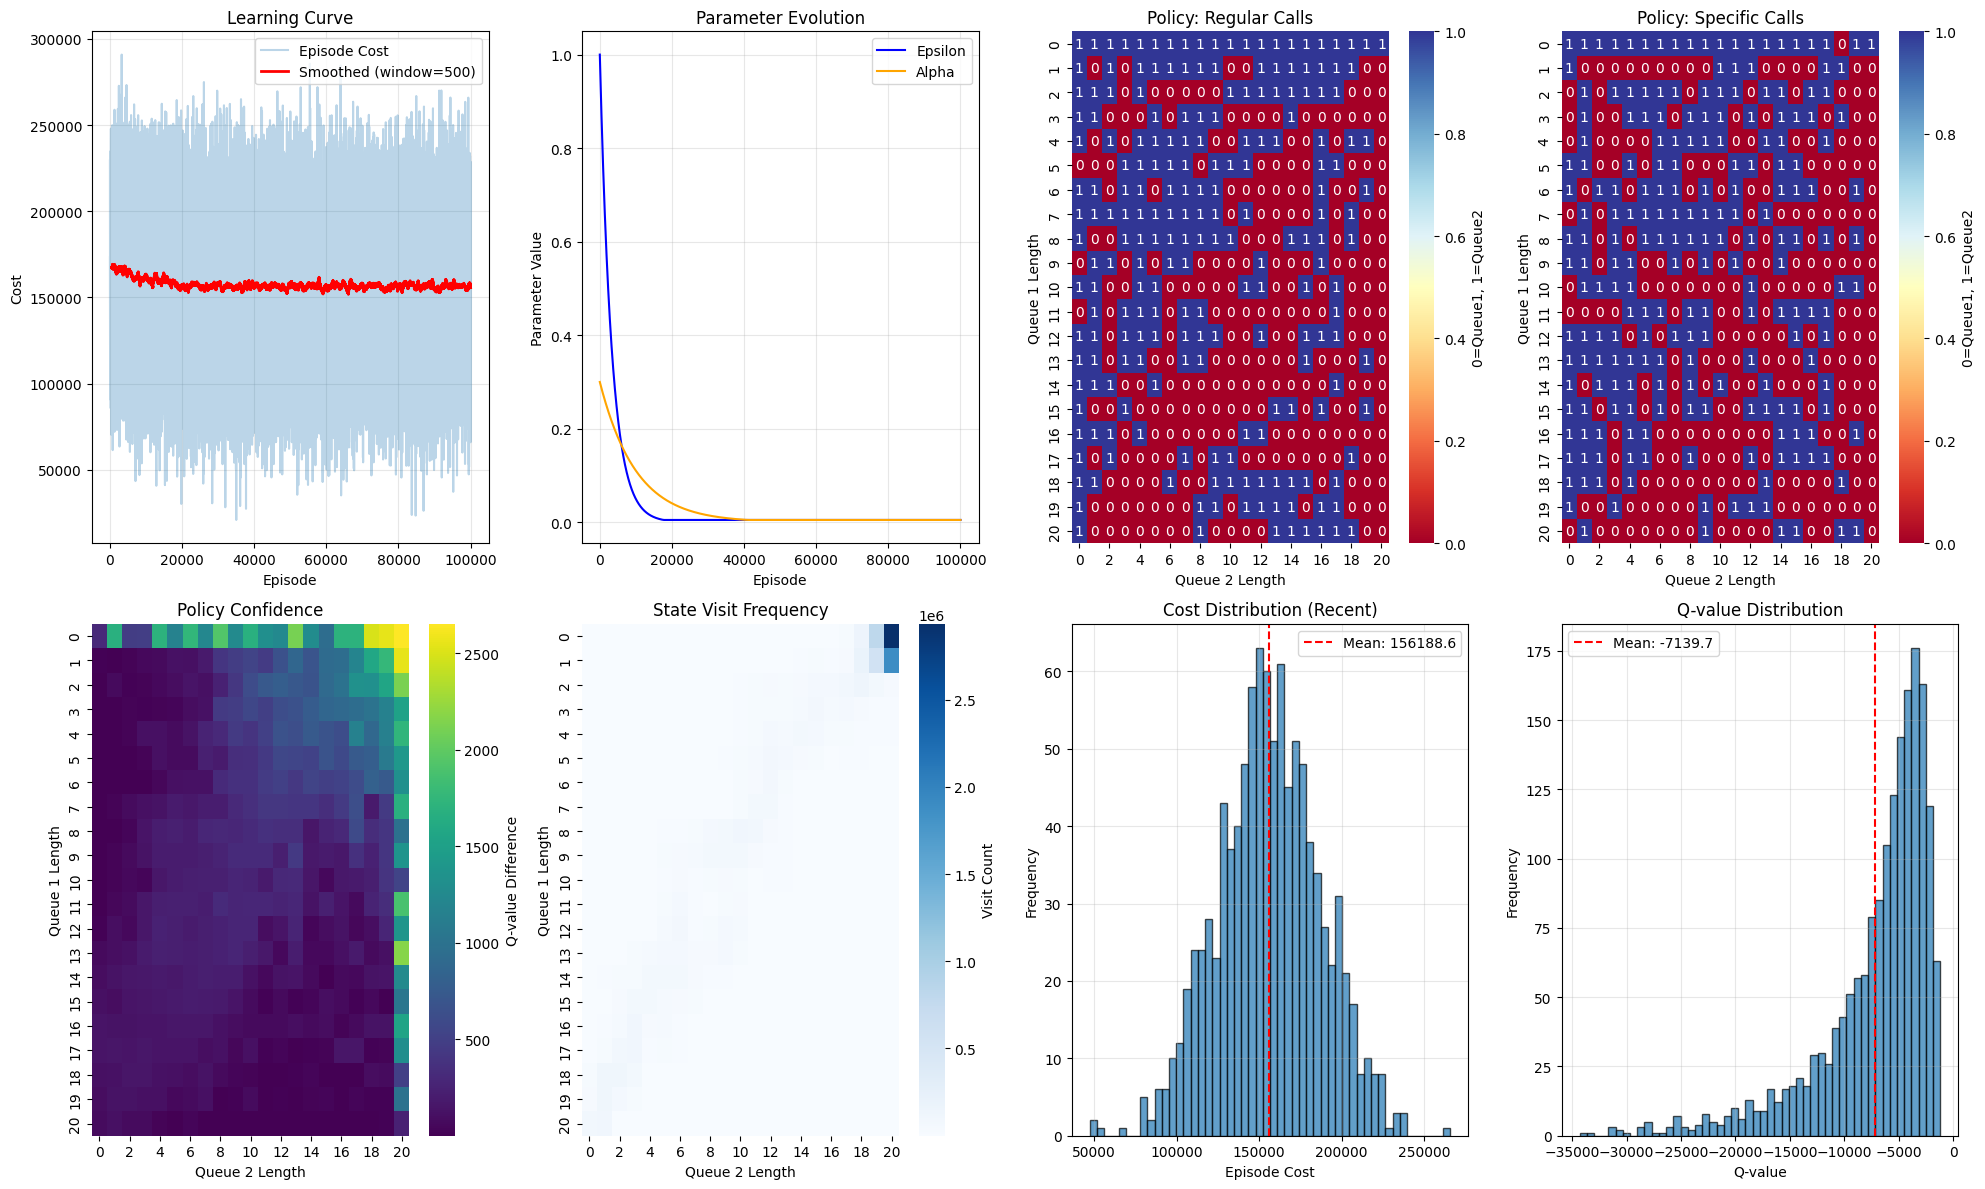

C:\Users\irfan\AppData\Local\Temp\ipykernel_39784\1177634301.py:148: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(evaluation_results, labels=['Baseline', 'Enhanced Q-Learning'])


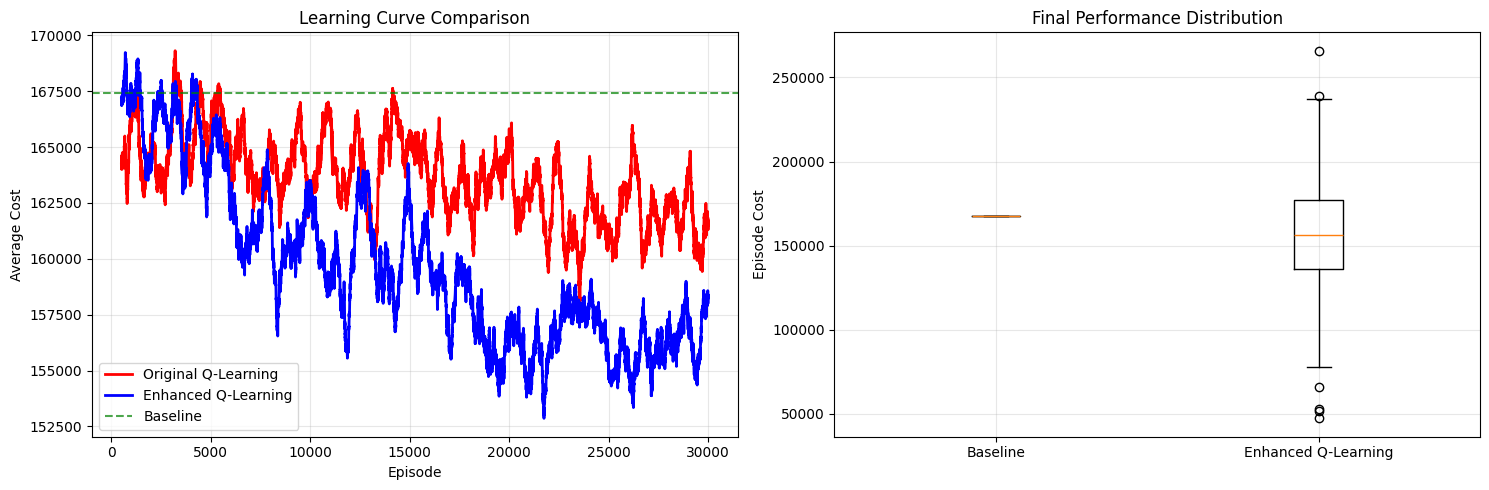


Training completed! Check the comprehensive plots above for detailed analysis.


In [18]:
if __name__ == "__main__":
    print("Enhanced Q-Learning for Call Centre Environment")
    print("=" * 60)
    
    # Use the same environment setup as your original code
    max_queue_size = MAX_QUEUE_SIZE
    drop_penalty = DROP_PENALTY
    scaler = 10.0 # Arrival scaler to attract more arrivals

    arrival_means = {
        0: ARRIVAL_REGULAR,
        1: ARRIVAL_SPECIFIC
    }
    
    service_means = {
        (1, 0): SERVICE_REGULAR_1,
        (1, 1): SERVICE_SPECIFIC_1,
        (2, 0): SERVICE_REGULAR_2,
        (2, 1): SERVICE_SPECIFIC_2
    }

    print(f"Regular call probability: {p_regular:.3f}")
    print(f"Service times (mean): Q1 Regular = {service_means[(1,0)]:.1f} s, Specific = {service_means[(1,1)]:.1f} s")
    print(f"                     Q2 Regular = {service_means[(2,0)]:.1f} s, Specific = {service_means[(2,1)]:.1f} s")
    print(f"Arrival times (mean): Regular = {arrival_means[0] / scaler:.1f} s, Specific = {arrival_means[1] / scaler:.1f} s")
    print("=" * 60)

    # Set seeds for reproducibility
    random.seed(1901448)
    np.random.seed(1901448)
    
    env = EventBasedCallCentreEnv(
        max_queue_size=max_queue_size,
        drop_penalty=drop_penalty,
        arr_scaler=scaler,
        arrival_regular_mean=arrival_means[0],
        arrival_specific_mean=arrival_means[1],
        service_regular_1=service_means[(1, 0)],
        service_specific_1=service_means[(1, 1)],
        service_regular_2=service_means[(2, 0)],
        service_specific_2=service_means[(2, 1)],
        seed=1901448
    )

    # Evaluate baseline first
    print("\n1. BASELINE EVALUATION:")
    baseline_cost, _, _ = random_baseline(env, num_episodes=1000)
    
    # Train and evaluate your original Q-learning
    print("\n2. ORIGINAL Q-LEARNING:")
    print("Training original Q-learning...")
    original_Q, original_costs = q_learning_with_debugging(
        env, num_episodes=30000, epsilon_min=0.01, epsilon_decay=0.9999, alpha=0.01
    )
    original_learned_cost, _, _ = evaluate_policy(env, original_Q, num_episodes=1000, policy_name="Original Q-Learning")
    
    # Train and evaluate enhanced Q-learning
    print("\n3. ENHANCED Q-LEARNING:")
    print("Training enhanced Q-learning...")
    
    # Reset environment seed for fair comparison
    env.seed(1901448)
    
    enhanced_agent = ImprovedQLearning(
        env=env,
        initial_alpha=0.3,
        min_alpha=0.005,
        alpha_decay=0.9999,
        gamma=0.95,
        initial_epsilon=1.0,
        min_epsilon=0.005,
        epsilon_decay=0.9997,
        exploration_bonus=100.0,  # Higher bonus for better exploration
        ucb_c=3.0,  # More aggressive UCB exploration
        use_ucb=True,
        use_load_balancing=True,  # Enable load balancing
        load_balance_weight=1.0
    )
    
    enhanced_Q, enhanced_costs = enhanced_agent.train(
        num_episodes=100000,
        max_steps_per_episode=200,
        print_every=5000
    )
    
    enhanced_learned_cost, _, _, _, _ = enhanced_evaluation(
        env, enhanced_Q, num_episodes=1000, policy_name="Enhanced Q-Learning"
    )
    
    # Final comparison
    print("\n" + "=" * 60)
    print("FINAL PERFORMANCE COMPARISON:")
    print("=" * 60)
    print(f"Baseline (Random Assignment):     {baseline_cost:.2f}")
    print(f"Original Q-Learning:           {original_learned_cost:.2f}")
    print(f"Enhanced Q-Learning:           {enhanced_learned_cost:.2f}")
    print()
    
    original_improvement = baseline_cost - original_learned_cost
    enhanced_improvement = baseline_cost - enhanced_learned_cost
    relative_improvement = original_learned_cost - enhanced_learned_cost
    
    print(f"Original improvement over baseline:  {original_improvement:.2f} ({(original_improvement/baseline_cost)*100:.2f}%)")
    print(f"Enhanced improvement over baseline:  {enhanced_improvement:.2f} ({(enhanced_improvement/baseline_cost)*100:.2f}%)")
    print(f"Enhanced improvement over original:  {relative_improvement:.2f} ({(relative_improvement/original_learned_cost)*100:.2f}%)")
    
    if enhanced_learned_cost < original_learned_cost:
        print("✅ Enhanced Q-Learning performs BETTER than original")
    else:
        print("❌ Enhanced Q-Learning performs WORSE than original")
    
    if enhanced_learned_cost < baseline_cost:
        print("✅ Enhanced Q-Learning beats baseline")
    else:
        print("❌ Enhanced Q-Learning loses to baseline")
    
    # Plot comprehensive results
    enhanced_agent.plot_comprehensive_results(max_queue_size=20)
    
    # Compare learning curves
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 2, 1)
    # Plot both learning curves
    window = 500
    if len(original_costs) > window:
        original_smoothed = pd.Series(original_costs).rolling(window).mean()
        plt.plot(original_smoothed[:30000], color='red', linewidth=2, label="Original Q-Learning")
    
    if len(enhanced_costs) > window:
        enhanced_smoothed = pd.Series(enhanced_costs).rolling(window).mean()
        plt.plot(enhanced_smoothed[:30000], color='blue', linewidth=2, label="Enhanced Q-Learning")
    
    plt.axhline(y=baseline_cost, color='green', linestyle='--', alpha=0.7, label="Baseline")
    plt.title("Learning Curve Comparison")
    plt.xlabel("Episode")
    plt.ylabel("Average Cost")
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    # Box plot comparison
    evaluation_results = [
        [baseline_cost] * 10,  # Baseline is deterministic
        [-r for r in enhanced_agent.episode_rewards[-1000:]],  # Convert to costs
    ]
    
    plt.boxplot(evaluation_results, labels=['Baseline', 'Enhanced Q-Learning'])
    plt.title("Final Performance Distribution")
    plt.ylabel("Episode Cost")
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\nTraining completed! Check the comprehensive plots above for detailed analysis.")

In [ ]:
original_Q

In [19]:
# Convert Q tables to numpy arrays for easier analysis
original_Q_np = {k: v.copy() for k, v in original_Q.items()}
enhanced_Q_np = {k: v.copy() for k, v in enhanced_Q.items()}

# Save the Q tables to pickle files for later use
with open('pickles/original_q_table.pkl', 'wb') as f:
    pickle.dump(original_Q_np, f)
with open('pickles/enhanced_q_table.pkl', 'wb') as f:
    pickle.dump(enhanced_Q_np, f)

### What to implement next:

* Implement Gym Environment
* Implement Q-Learning
* Implement PPO